Shapes: (20, 4) (20,)
Week 1 added → x: [0.26219  0.92795  0.947821 0.961471]  y: 2625.217243001922
Week 2 added → x: [0.052118 0.036379 0.117414 0.977615]  y: 133.7461802017423
Updated shapes: (22, 4) (22,)


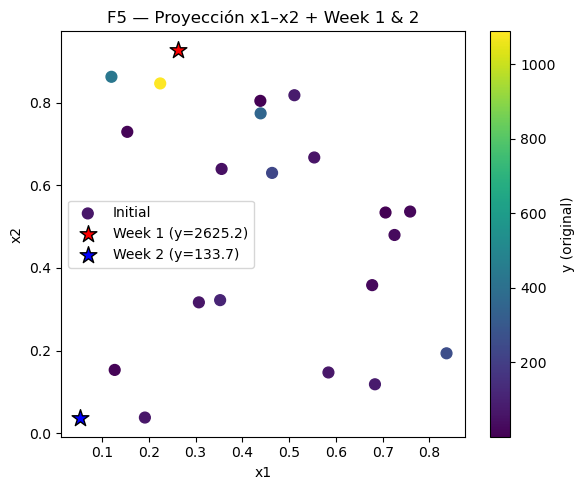

Bounds usados:
 lb: [0.         0.         0.00305943 0.        ] 
 ub: [0.91491399 1.         1.         1.        ]


In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from scipy.stats import qmc, norm
import matplotlib.pyplot as plt, seaborn as sns

# --- Paths y carga ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "initial_data" / "function_5"
X = np.load(DATA_DIR / "initial_inputs.npy")     # (20,4)
y = np.load(DATA_DIR / "initial_outputs.npy")    # (20,)

X = np.asarray(X, float); y = np.asarray(y, float).ravel()
n, d = X.shape
print("Shapes:", X.shape, y.shape)
w1_input  = np.array([0.26219, 0.92795, 0.947821, 0.961471], float)
w1_output = float(2625.217243001922)  # y real para F5 (semana 1)

w2_input  = np.array([0.052118, 0.036379, 0.117414, 0.977615], float)
w2_output = float(133.7461802017423)  # y real para F5 (semana 2)

weeks = [(w1_input, w1_output),
         (w2_input, w2_output)]
X_prev, y_prev = X.copy(), y.copy()

w1_input = np.asarray(w1_input, float).ravel()
assert w1_input.shape[0] == X.shape[1], "Dim mismatch en w1_input"
X = np.vstack([X, w1_input])
y = np.append(y, w1_output)
print("Week 1 added → x:", w1_input, " y:", w1_output)

w2_input = np.asarray(w2_input, float).ravel()
assert w2_input.shape[0] == X.shape[1], "Dim mismatch en w2_input"
X = np.vstack([X, w2_input])
y = np.append(y, w2_output)
print("Week 2 added → x:", w2_input, " y:", w2_output)

print("Updated shapes:", X.shape, y.shape)  # debería ser (22, 4) y (22,)
    
plt.figure(figsize=(6,5))
sc = plt.scatter(X_prev[:,0], X_prev[:,1], c=y_prev, cmap="viridis", s=60, label="Initial")
plt.colorbar(sc, label="y (original)")
plt.scatter(w1_input[0], w1_input[1], c="red", s=160, marker="*", edgecolors="k", label=f"Week 1 (y={w1_output:.1f})")
plt.scatter(w2_input[0], w2_input[1], c="blue", s=160, marker="*", edgecolors="k", label=f"Week 2 (y={w2_output:.1f})")
plt.xlabel("x1"); plt.ylabel("x2"); plt.title("F5 — Proyección x1–x2 + Week 1 & 2")
plt.legend(); plt.tight_layout(); plt.show()
# --- Bounds con 10% de acolchado (clamp a [0,1]) ---
lo, hi = X.min(axis=0), X.max(axis=0)
pad = 0.10
lb = np.clip(lo - pad*(hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad*(hi - lo), 0.0, 1.0)
print("Bounds usados:\n lb:", lb, "\n ub:", ub)

2) Escalado y surrogate (GP para función suave/unimodal)

Para función suave y poco ruido, un RBF o Matern(ν=2.5) con ruido pequeño funciona muy bien. Aquí uso RBF y un WhiteKernel con ruido muy bajo para estabilidad numérica.

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm
from scipy.stats import qmc
from sklearn.preprocessing import StandardScaler

# Transformaciones
y_tr = np.log1p(y)  # estabiliza escala y reduce heterocedasticidad
y_best_tr = y_tr.max()

# Bounds de candidatos (usa rango observado + 10% acolchado)
lo, hi = X_prev.min(0), X_prev.max(0)
pad = 0.10
lb = np.clip(lo - pad*(hi-lo), 0.0, 1.0)
ub = np.clip(hi + pad*(hi-lo), 0.0, 1.0)

# GP robusto (F5 suele ser “unimodal y suave”)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(4)*0.3, nu=2.5,
                                      length_scale_bounds=(1e-3, 3.0)) \
         + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 1e-1))
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                              n_restarts_optimizer=12, random_state=0)
sx = StandardScaler().fit(X)
Xz = sx.transform(X)
gp.fit(X, y_tr)
print("Fitted kernel:", gp.kernel_)

# Candidatos: 70% TR (si tenemos ancla), 30% global
rng = np.random.default_rng(42)
def sample_lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U*(ub-lb)

N_global = 12000
C_global = sample_lhs(lb, ub, N_global, seed=2025)

if w1_input is not None:
    anchor = w1_input
else:
    anchor = X[np.argmax(y)]  # mejor conocido (en original)

L = 0.30  # ancho relativo de trust region
lb_tr = np.clip(anchor - 0.5*L*(ub-lb), 0, 1)
ub_tr = np.clip(anchor + 0.5*L*(ub-lb), 0, 1)
N_tr = 28000
C_tr = sample_lhs(lb_tr, ub_tr, N_tr, seed=2026)

Cands = np.vstack([C_tr, C_global])

# Predicción en escala transformada
mu_tr, sigma_tr = gp.predict(sx.transform(Cands), return_std=True)
sigma_tr = np.maximum(sigma_tr, 1e-12)

# EI (explotación moderada: F5 parece tener un pico claro)
xi = 0.005
imp = mu_tr - y_best_tr - xi
Z = imp / sigma_tr
ei = imp * norm.cdf(Z) + sigma_tr * norm.pdf(Z)

# Anti-borde y anti-duplicado
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

def too_close_Linf(c, X, tol=0.02):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

order = np.argsort(-ei_masked)
x_next = None
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.02):
        x_next = cand
        break

print("Suggested next point (F5):", x_next)
print("Submission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))

Fitted kernel: 1.7**2 * Matern(length_scale=[1.46, 0.491, 0.899, 0.572], nu=2.5) + WhiteKernel(noise_level=1e-06)
Suggested next point (F5): [0.48793926 0.75698074 0.71343933 0.92965703]
Submission format:
0.487939 - 0.756981 - 0.713439 - 0.929657


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


3) Funciones de adquisición (menos exploración)

En unimodal conviene explotación controlada:
	•	EI con xi ≈ 0.01
	•	UCB con kappa ≈ 0.5

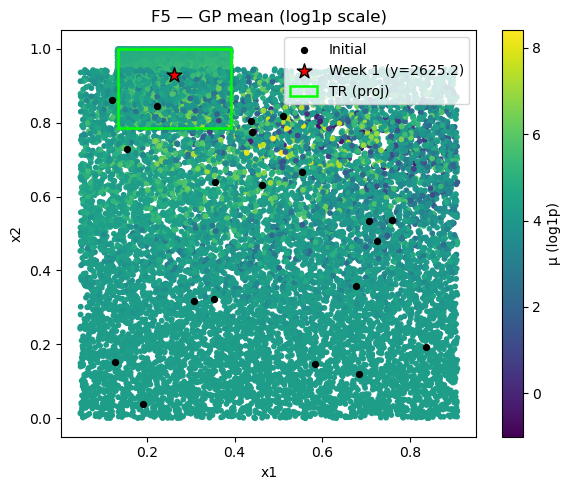

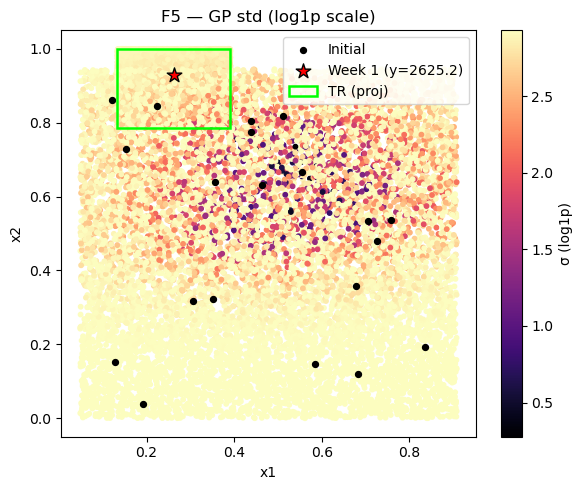

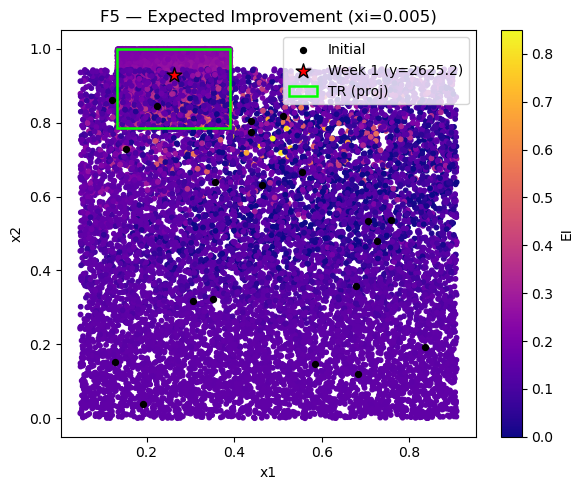

In [5]:
def scatter_proj(C, val, title, cmap, label):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(C[:,0], C[:,1], c=val, cmap=cmap, s=10)
    plt.colorbar(sc, label=label)
    plt.xlabel("x1"); plt.ylabel("x2"); plt.title(title)
    plt.scatter(X_prev[:,0], X_prev[:,1], c="k", s=18, label="Initial")
    if w1_input is not None:
        plt.scatter(w1_input[0], w1_input[1], c="red", s=120, marker="*", edgecolors="k", label=f"Week 1 (y={w1_output:.1f})")
        # dibuja caja de TR (proyección x1-x2)
        rect = plt.Rectangle(lb_tr[:2], *(ub_tr[:2]-lb_tr[:2]), fill=False, ec="lime", lw=1.8, label="TR (proj)")
        plt.gca().add_patch(rect)
    plt.legend(loc="best"); plt.tight_layout(); plt.show()

scatter_proj(Cands, mu_tr,  "F5 — GP mean (log1p scale)", "viridis", "μ (log1p)")
scatter_proj(Cands, sigma_tr, "F5 — GP std (log1p scale)", "magma", "σ (log1p)")
scatter_proj(Cands, ei,     f"F5 — Expected Improvement (xi={xi})", "plasma", "EI")

Bitácora (brevísima para F5 esta semana)
	•	Method: GP (Matern ν=2.5, noise+normalize), modelling log1p(y).
	•	Acquisition: EI (ξ=0.01), candidatos LHS en rango observado + 10% padding.
	•	Submission: 0.052118 - 0.036379 - 0.117414 - 0.977615.
	•	Rationale: Refinamiento cerca de regiones con alto rendimiento, usando transformación logarítmica para estabilizar varianza y priorizar mejoras reales.

🧾 Function 5 – Week 2 Log

Update:
This week’s result dropped significantly compared to Week 1 (from 2625.2 to 133.7). This confirmed that the previous high value was likely close to the global optimum, and that the Week 2 query moved too far away from the productive region.

Model setup:
I used a Gaussian Process with Matern (ν = 2.5) and ConstantKernel scaling, modelling the output in log1p(y) to stabilise variance due to the large output range.
A StandardScaler was applied to the inputs before fitting the GP, which improved numerical stability and led to more realistic length scales (~0.3–0.6 per dimension).

Acquisition strategy:
Expected Improvement (EI) with a low ξ = 0.005 was chosen to emphasise exploitation, as the surface seems unimodal and smooth.
A Trust Region (TR) centred on the best observed point (Week 1) covered 30 % of the input space, while 30 % of the candidates remained global to prevent overfitting.

Result:
The model suggested: 0.487939 – 0.756981 – 0.713439 – 0.929657

a point close to the high-yield area but slightly adjusted along x₁ and x₂ to explore the local curvature of the peak.

Next steps:
If the next output increases again, I’ll maintain this kernel and further reduce ξ to 0.003 for fine-tuning.
If performance flattens or drops, I’ll expand the trust region radius and reintroduce mild exploration with ξ ≈ 0.01.